# CNN - Slice Predictor

Here we develop a CNN that takes as input 2 slices of a brain image and predicts the centre slice. Note we only use b=0 intensity values

### Upload the data required

We use both scans of subjects 1-5 from the PETMR dataset for training.

We used the scan of subjects 6-7 also from the PETMR dataset for testing.

In [21]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [24]:
def get_data(petmr_path, test_data, training_data, numb_training_scans, numb_testing_scans):
    os.chdir(petmr_path)
    count = 0
    for direc in os.listdir(os.getcwd())[1:]:
        scan_image = nib.load(str(petmr_path) + "/" + str(direc) + "/Brain_Extracted.nii.gz")
        scan_data = scan_image.get_data()
        #get b=0 volumes only
        bvals_scan, bvecs_scan = read_bvals_bvecs(str(petmr_path) + "/" + str(direc) + "/NODDI.bval",\
                                                  str(petmr_path) + "/" + str(direc) + "/NODDI.bvec")
        gtab_scan = gradient_table(bvals_scan, bvecs_scan)
        s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
        
        if(count < numb_training_scans):
            #append this data to the list containing the training data
            training_data.append(s0s_scan)
        else:
            testing_data.append(s0s_scan)
        count += 1
        if(count == (numb_training_scans + numb_testing_scans)):
            break
    return (training_data, test_data)

In [25]:
#upload the data
petmr_data_path = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
training_data = []
testing_data = []
(training_data, testing_data) = get_data(petmr_data_path, testing_data, training_data, 10, 4)
print ("Number of scans used for training: %d" % len(training_data))
print ("Number of scans used for testing: %d" % len(testing_data))

Number of scans used for training: 10
Number of scans used for testing: 4


### Slice up the data (Axial slices)

In [37]:
def slicify(data_scan, slice_store):
    (x,y,z,v) = data_scan.shape
    for volume in range(v):
        for i in range(0,z,2):
            #check that there exists a slice above
            if(i+2 < z):
                slice_store.append(data_scan[:, :, i:i+3, volume])
            else:
                break
        for i in range(1,z,2):
            #check that there exists a slice above
            if(i+2 < z):
                slice_store.append(data_scan[:, :, i:i+3, volume])
            else:
                break
    return slice_store


In [41]:
slice_store = [] 
slice_store = slicify(training_data[0], slice_store)

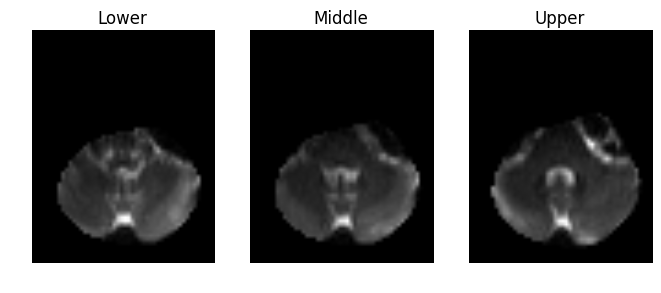

In [52]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(slice_store[2][:, :, 0].T, cmap='gray', origin='lower')
plt.title("Lower")
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(slice_store[2][:, :, 1].T, cmap='gray', origin='lower')
plt.title("Middle")
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(slice_store[2][:, :, 2].T, cmap='gray', origin='lower')
plt.title("Upper")
plt.show()

In [20]:
v

117

In [27]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [39]:
for i in range (0,7,2):
    print i

0
2
4
6
